In [1]:
from sklearn.feature_selection import SelectFdr, f_classif
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wilcoxon
from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif,f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, mean_squared_error, precision_score, jaccard_score, fowlkes_mallows_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from boruta import BorutaPy
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.model_selection import train_test_split

In [7]:
rna = pd.read_csv('D:/multiomics/2025june/rna_rb.csv', sep=',')
lipid = pd.read_csv('D:/multiomics/2025june/lipid_rb.csv', sep=',')
meta = pd.read_csv('D:/multiomics/2025june/meta_rb.csv', sep=',')

In [8]:
sets_to_intersect = [
    set(rna['id']),
    set(lipid['id']),
    set(meta['id'])
]


common_ids = set.intersection(*sets_to_intersect)


sorted_common_ids = sorted(common_ids)

meta = meta[meta['id'].isin(common_ids)].set_index('id').loc[sorted_common_ids].reset_index()
lipid = lipid[lipid['id'].isin(common_ids)].set_index('id').loc[sorted_common_ids].reset_index()
rna = rna[rna['id'].isin(common_ids)].set_index('id').loc[sorted_common_ids].reset_index()

In [9]:
sum(rna['id']==meta['id']),sum(rna['id']==lipid['id'])

(250, 250)

In [10]:
def get_quantile(X_train, column_name,new_column_name,a,b,position):

    percentile_a = X_train[column_name].quantile(a)
    percentile_b = X_train[column_name].quantile(b)


    X_train[new_column_name] = 0
    X_train.loc[X_train[column_name] >= percentile_a, new_column_name] = 1

    column_to_move = new_column_name
    target_column = position

    column = X_train.pop(column_to_move)
    X_train.insert(target_column, column_to_move, column)
    
    return X_train

In [17]:
rna = get_quantile(rna, 'sVNT_M1_WT_RBD_10_times_dilution','sVNT_M1_WT_RBD',0.75,0,10)
meta = meta.reset_index(drop=True)
lipid = lipid.reset_index(drop=True)
rna = rna.reset_index(drop=True)

C:\Users\win11\AppData\Local\Temp\ipykernel_110328\343122402.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train.insert(target_column, column_to_move, column)


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

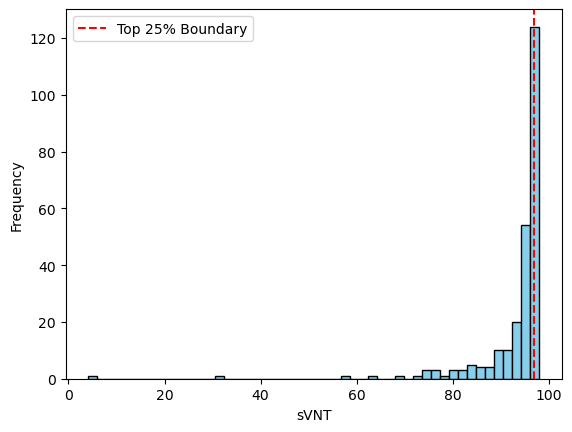

In [21]:
df_sorted = rna.sort_values(by= 'sVNT_M1_WT_RBD_10_times_dilution', ascending=False)

top_25_percent_index = int(len(df_sorted) * 0.25)
top_25_values = df_sorted.iloc[:top_25_percent_index]

plt.hist(rna[ 'sVNT_M1_WT_RBD_10_times_dilution'], bins=50, color='skyblue', edgecolor='black') 
plt.xlabel('sVNT') 
plt.ylabel('Frequency')  


plt.axvline(x=top_25_values.iloc[-1]['sVNT_M1_WT_RBD_10_times_dilution'], color='red', linestyle='--', label='Top 25% Boundary')
plt.legend()  
plt.show()  

In [26]:
f_rna = rna.iloc[:,14:]
f_lipid = lipid.iloc[:,6:]
f_meta = meta.iloc[:,6:]
f_agender = rna.iloc[:,1:3]
label = rna.iloc[:,10]

In [28]:
rna[['Batch','sVNT_M1_WT_RBD']]

,Batch,sVNT_M1_WT_RBD
0,Batch01,1
1,Batch02,0
2,Batch02,0
3,Batch01,1
4,Batch02,0
...,...,...
245,Batch02,0
246,Batch01,0
247,Batch01,0
248,Batch01,0


In [29]:
cross_table = pd.crosstab(rna['sVNT_M1_WT_RBD'], rna['Batch'])

In [30]:
cross_table

Batch,Batch01,Batch02
sVNT_M1_WT_RBD,,
0,86,101
1,35,28


In [33]:
combine = pd.concat([f_rna, f_lipid, f_meta], axis=1) 
combine = pd.concat([f_agender, combine], axis=1)

In [35]:
bl = (
    rna['Batch'].astype(str).str.cat(rna['sVNT_M1_WT_RBD'].astype(str), sep='_')
)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combine, label, test_size=0.2,stratify=bl,random_state=42)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,bl.shape

((200, 44946), (50, 44946), (200,), (50,), (250,))

In [38]:
bl[X_train.index]

222    Batch01_0
188    Batch01_0
246    Batch01_0
228    Batch01_0
25     Batch02_0
         ...    
215    Batch01_1
82     Batch02_0
104    Batch01_0
74     Batch02_0
190    Batch01_0
Name: Batch, Length: 200, dtype: object

In [44]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import f_classif
from joblib import Parallel, delayed
import pandas as pd

def process_fold(train_idx, val_idx, i, X_train, y_train):
    print(f"Processing fold {i}")
    
    X_fold_train, y_fold_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    
    F_values, p_values = f_classif(X_fold_train, y_fold_train)
    significant_features_mask = p_values < 0.05
    significant_features = X_fold_train.columns[significant_features_mask]
    print(f"Fold {i+1}: {len(significant_features)} significant features")
    X_fold_train_sig = X_fold_train[significant_features]
    estimator = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    boruta_selector = BorutaPy(
        estimator=estimator,
        n_estimators='auto',  
        verbose=0,           
        random_state=42,
        max_iter=100,        
        perc=95,alpha=0.05         
    )
    

    boruta_selector.fit(X_fold_train_sig.values, y_fold_train.values)
    

    selected_features_mask = boruta_selector.support_
    selected_features = significant_features[selected_features_mask]
    

    estimator.fit(X_fold_train_sig[selected_features], y_fold_train)
    importances = estimator.feature_importances_

    return [
        {
            'fold': i,
            'feature': feature,
            'importance': importance,
        }
        for feature, importance in zip(selected_features, importances)
    ]


def main():

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(partial(process_fold, X_train=X_train, y_train=y_train))(train_idx, val_idx, i)
        for i, (train_idx, val_idx) in enumerate(cv.split(X_train, bl[X_train.index]))
    )
    
    results = [item for sublist in results for item in sublist]
    
    results_df = pd.DataFrame(results)
    
    results_df = results_df.sort_values(['fold', 'importance'], ascending=[True, False])
    
    print(results_df.head())
    return results_df

if __name__ == '__main__':
    all_feature_counts = main()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.6min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.7min remaining:   42.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


    fold                                  feature  importance
36     0  ENSG00000213221.5__DNLZ__protein.coding    0.022925
24     0   ENSG00000172965.17__MIR4435.2HG__ncRNA    0.019891
60     0                ENSG00000268518.1__NA__NA    0.019303
30     0  ENSG00000187193.9__MT1X__protein.coding    0.018366
71     0                ENSG00000280466.1__NA__NA    0.018241


In [45]:
all_feature_counts

,fold,feature,importance
36,0,ENSG00000213221.5__DNLZ__protein.coding,0.022925
24,0,ENSG00000172965.17__MIR4435.2HG__ncRNA,0.019891
60,0,ENSG00000268518.1__NA__NA,0.019303
30,0,ENSG00000187193.9__MT1X__protein.coding,0.018366
71,0,ENSG00000280466.1__NA__NA,0.018241
...,...,...,...
774,9,ENSG00000171658.8__NMRAL2P__pseudo,0.006275
820,9,ENSG00000272905.1__NA__NA,0.005669
756,9,ENSG00000117010.17__ZNF684__protein.coding,0.005292
796,9,ENSG00000222042.2__NA__NA,0.004624


In [54]:
feature_counts = all_feature_counts['feature'].value_counts()
common_features = feature_counts[feature_counts >= 5].index
df_filtered = all_feature_counts[all_feature_counts['feature'].isin(common_features)]

stats = df_filtered.groupby('feature')['importance'].agg(['sum', 'mean', 'count'])
stats = stats.sort_values('mean', ascending=False)

top_feature = stats.index[:33]
feature_selected = list(top_feature)

In [56]:
feature_selected

['ENSG00000182853.12__VMO1__protein.coding',
 'ENSG00000204172.12__AGAP9__protein.coding',
 'ENSG00000256407.2__NA__NA',
 'ENSG00000268518.1__NA__NA',
 'ENSG00000196295.13__NA__NA',
 'ENSG00000159556.10__ISL2__protein.coding',
 'ENSG00000280466.1__NA__NA',
 'ENSG00000261270.1__NA__NA',
 'ENSG00000155761.14__SPAG17__protein.coding',
 'ENSG00000177300.7__CLDN22__protein.coding',
 'HMDB0029688__.beta..Naphthol.ethyl.ether',
 'ENSG00000288851.1__NA__NA',
 'HMDB0031162__UF7990000',
 'HMDB0012843__6.Hydroxycaproic.acid',
 'ENSG00000133661.17__SFTPD__protein.coding',
 'ENSG00000242611.2__NA__NA',
 'ENSG00000172965.17__MIR4435.2HG__ncRNA',
 'ENSG00000187091.14__PLCD1__protein.coding',
 'HMDB0032699__.2..2..Isobutyryloxy..4.methylphenyl..2.oxiranyl.methyl.2.methylbutanoate',
 'ENSG00000149243.17__KLHL35__protein.coding',
 'ENSG00000168899.5__VAMP5__protein.coding',
 'ENSG00000289629.1__NA__NA',
 'ENSG00000286681.1__NA__NA',
 'ENSG00000234745.13__HLA.B__protein.coding',
 'ENSG00000214253.9__FIS1

In [60]:
# Prepare training and test sets
Xtrain = X_train[['Age', 'Gender'] + feature_selected]
Xtest = X_test[['Age', 'Gender'] + feature_selected]

# Initialize and train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(Xtrain, y_train)

# Predict probabilities for the positive class
y_pred_proba = rf.predict_proba(Xtest)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

print(f'{auc:.2f}')

0.73
